<a href="https://colab.research.google.com/github/XimenaLimon/4-methylphthalic-acid-and-its-related-anhydride./blob/main/4MPAc_article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine learning applied to determine enthalpies of formation, combustion, and sublimation of 4-methylphthalic acid and its related anhydride.**

In [ ]:
#Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, LearningCurveDisplay, ShuffleSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
import re

In [ ]:
#Data set
#Use the data set according to the enthalpy to be predicted
#Combustion.csv, Sublimation.csv, Formation_g.csv or Formation_cr.csv
Data=pd.read_csv("/content/drive/MyDrive/4mca/Combustion.csv")
pd.set_option("display.max_rows",None)

In [ ]:
#Function to extract the number of atoms from the compact chemical formula
def parse_formula(formula):
    #Regular expression
    matches = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    element_counts = {}
    for (element, count) in matches:
        count = int(count) if count else 1  #If there is no number, 1 is assumed
        element_counts[element] = count
    return element_counts

#Processing of compact chemical formulas
formula_data = Data['Formula'].apply(parse_formula)

#Dataframe with the number of atoms
elements = pd.DataFrame(list(formula_data)).fillna(0)
Data=pd.concat([Data,elements],axis=1)

<Axes: ylabel='-∆fH°'>

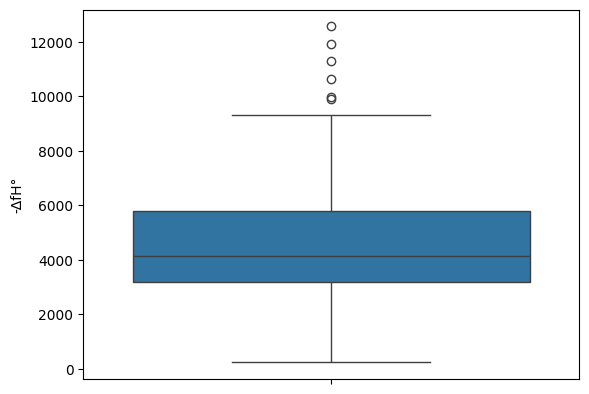

In [ ]:
#Box plot shows outliers with interquartile range criteria
sns.boxplot(Data["-∆cH°"])

In [ ]:
#Identification of outliers
#Combustion: contamination --> 0.11
#Formation gas phase: contamination --> 0.01
#Formation cr phase: contamination --> 0, because it has no outliers
#Sublimation: contamination --> 0.02
iso = IsolationForest(contamination=0.11, random_state=42)
Data['outliers'] = iso.fit_predict(Data[['-∆cH°']])
outliers = Data[Data['outliers'] == -1]
Data.drop(outliers.index, inplace=True)

<Axes: ylabel='-∆fH°'>

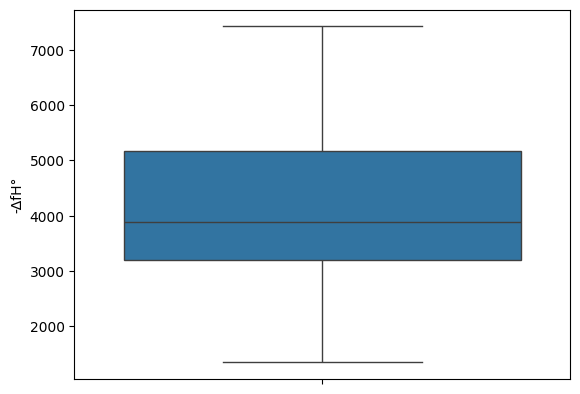

In [ ]:
#Boxplot without outliers removed with isolation forest
sns.boxplot(Data["-∆cH°"])

In [ ]:
#Definition of variables
X=Data.iloc[:,3:]
y=Data.iloc[:-1,2]

In [ ]:
#Obtaining variables
pd.set_option("display.max_columns",None)
dummies=pd.get_dummies(X[["group","Correction 1","Correction 2","Correction 3","Correction 4"]], drop_first=True)
X=X.drop(["group","Correction 1","Correction 2","Correction 3","Correction 4"],axis=1)
C=pd.concat([X,dummies],axis=1)


In [ ]:
#Compounds to predict
Compounds=C.iloc[:-1,:]
#predictions=C.loc[73,:]

#The number of data depends on the data set of each enthalpy that you want to predict.

#For Enthalpy of combustion use:
isomers=C.loc[95:,:]

#For Enthalpy of sublimation use:
#isomers=C.loc[72:,:]

#For Enthalpy of formation in gas phase use:
#isomers=C.loc[82:,:]

#For Enthalpy of formation in crystalline phase use:
#isomers=C.loc[98:,:]

# **Ridge Regression**

In [ ]:
RandomState=[]
BEST_ALPHA=[]
BEST_MODEL=[]
RMSE_TRAIN=[]
RMSE_TEST=[]
MAE_TRAIN=[]
MAE_TEST=[]
R2_TRAIN=[]
R2_TEST=[]

#Iterations for random state in the train_test_split method
for random_state in np.arange(0,1000,1):
    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(Compounds,y, test_size=0.3, random_state=random_state)

    #Pipeline. This to add preprocessing steps if necessary.
    pipeline = Pipeline([('ridge', Ridge())
    ])

    #The value of the regularization is varied
    param_grid = {
        'ridge__alpha': [0.01, 0.1, 1, 10, 100]
    }

    #Grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error')
    grid_search.fit(X_train, y_train)

    #Getting the best parameters and fitted model for each iteration of random_state
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    #Predict and calculate evaluation metrics
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    #Store results
    RandomState.append(random_state)
    BEST_ALPHA.append(best_params['ridge__alpha'])
    BEST_MODEL.append(best_model)
    RMSE_TRAIN.append(rmse_train)
    RMSE_TEST.append(rmse_test)
    MAE_TRAIN.append(mae_train)
    MAE_TEST.append(mae_test)
    R2_TRAIN.append(r2_train)
    R2_TEST.append(r2_test)





In [ ]:
#Find models with a relative difference of less than 10% between RMSE of the training and test set
RD=[]
for i,j,k in zip(RMSE_TEST,RMSE_TRAIN,RandomState):
  relative_diff=((i-j)/j)*100
  RD.append(relative_diff)
  if relative_diff<10:
    print(i,j,k, abs(relative_diff))


24.007977654517447 22.496088017973555 427 6.720677992262241


In [ ]:
#The results are added in a dataframe
results_df=pd.DataFrame(data=list(zip(RandomState, BEST_ALPHA, RMSE_TRAIN,
                                      RMSE_TEST, MAE_TRAIN, MAE_TEST,
                                      R2_TRAIN, R2_TEST)), columns=["RandomState", "BestAlpha","RMSE_Train",
                                                                    "RMSE_Test", "MAE_Train","MAE_Test",
                                                                    "R2_Train","R2_Test"])

In [ ]:
#Predictions with the best model
#random state = 427, alpha = 1 combustion
#random state = 329, alpha = 0.9 formation cr phase
#random state = 644, alpha =  1.5 formation g phase
#random state = 159, alpha = 0.95 sublimation
X_train, X_test, y_train, y_test = train_test_split(Compounds.drop(["outliers"],axis=1),y, test_size=0.3, random_state=427)
model=Ridge(alpha=1, solver="auto")
model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [ ]:
#Evaluation metrics
rmse_train=root_mean_squared_error(y_train,y_pred_train)
rmse_test=root_mean_squared_error(y_test,y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f"RMSE Test: {rmse_test}")
print(f"RMSE Train: {rmse_train}")
print(f"MAE Test: {mae_test}")
print(f"MAE Train: {mae_train}")
print(f"R2 Test: {r2_test}")
print(f"R2 Train: {r2_train}")

RMSE Test: 24.00797765451729
RMSE Train: 22.49608801797355
MAE Test: 17.172183219399987
MAE Train: 16.22349673869582
R2 Test: 0.9996550058569739
R2 Train: 0.9997818994661448


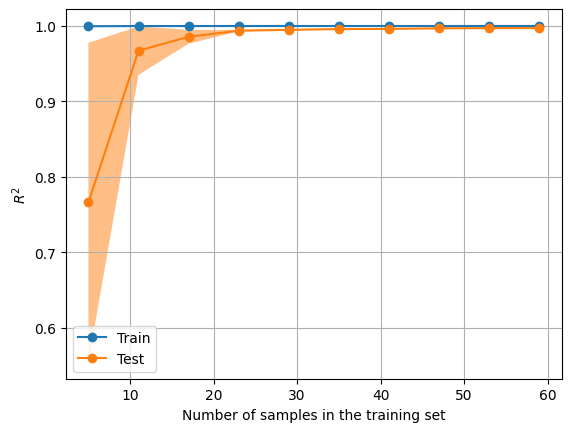

In [ ]:
#Learning curve
common_params = {
    "X": Compounds.drop(["outliers"],axis=1),
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits=5, test_size=0.3, random_state=0),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "$R^2$",
}

LearningCurveDisplay.from_estimator(model, **common_params)
plt.grid()
plt.show()

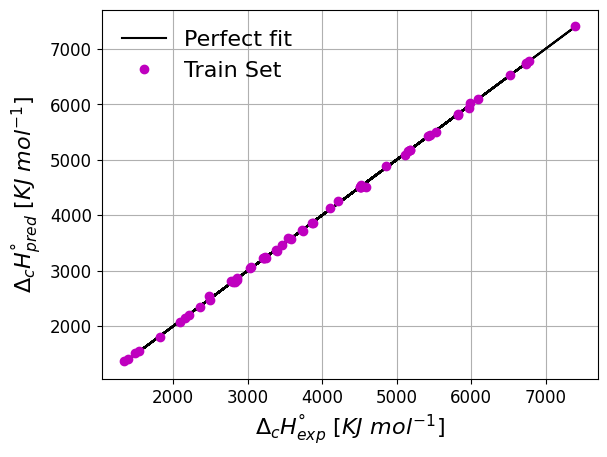

In [ ]:
#Parity diagram for training set
plt.style.use('default')
plt.tick_params(labelsize=12)
plt.plot(y_train,y_train, "k-", label="Perfect fit")
plt.plot(y_train, y_pred_train, "mo", label="Train Set")
plt.xlabel("$\Delta_{c}H^{°}_{exp}$ $[KJ\ mol^{-1}$]", size=16)
plt.ylabel("$\Delta_{c}H^{°}_{pred}$ $[KJ\ mol^{-1}$]", size=16)
plt.grid()
plt.legend(loc="best", prop={"size":16}, frameon=False)
plt.show()

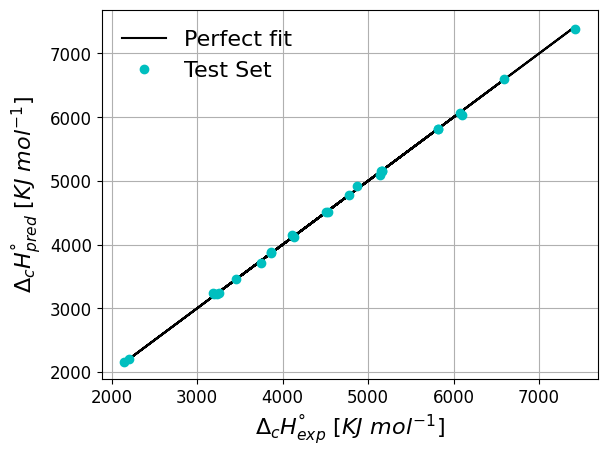

In [ ]:
#Parity diagram for test set
plt.style.use('default')
plt.tick_params(labelsize=12)
plt.plot(y_test,y_test, "k-", label="Perfect fit")
plt.plot(y_test, y_pred_test, "co", label="Test Set")
plt.xlabel("$\Delta_{c}H^{°}_{exp}$ $[KJ\ mol^{-1}$]", size=16)
plt.ylabel("$\Delta_{c}H^{°}_{pred}$ $[KJ\ mol^{-1}$]", size=16)
plt.grid()
plt.legend(loc="best", prop={"size":16}, frameon=False)
plt.show()

In [ ]:
#Retrain the model with the data set
model=model.fit(Compounds.drop(["outliers"],axis=1),y)

In [ ]:
#y_compounds=model.predict([isomers.drop(index=["outliers"])])
y_compounds=model.predict(isomers.drop(["outliers"],axis=1))
print(y_compounds)

[3862.27401535 3893.71575252]


In [ ]:
#Contributions
Contribution=list(Compounds.drop(["outliers"],axis=1).columns)
coef=list(model.coef_)
Benson=pd.DataFrame(data=list(zip(Contribution, coef)), columns=["Group", "Value"])
model.intercept_.round(2)

-95.14

In [ ]:
#We export the data
Benson.to_csv("Combustion_contributions.csv")